### Logistic Regression

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 
- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
import datasetup
from datasetup import churndata, colors, palette
sns.set_palette(palette)
%matplotlib inline

In [2]:
filepath = 'Human_Activity_Recognition_Using_Smartphones_Data.csv'
data = pd.read_csv(filepath, sep=',')

In [3]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


In [4]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [5]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [6]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [7]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [8]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. \
A `LabelEncoder` needs to be used to convert the activity labels to integers. \
We will fit_transform the "Activity" column, and look at 5 random values.

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

1977    0
2335    4
5759    0
8672    4
9989    0
Name: Activity, dtype: int32

* correlations between the dependent variables.
* Identify the most correlated (either positively or negatively).

In [10]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

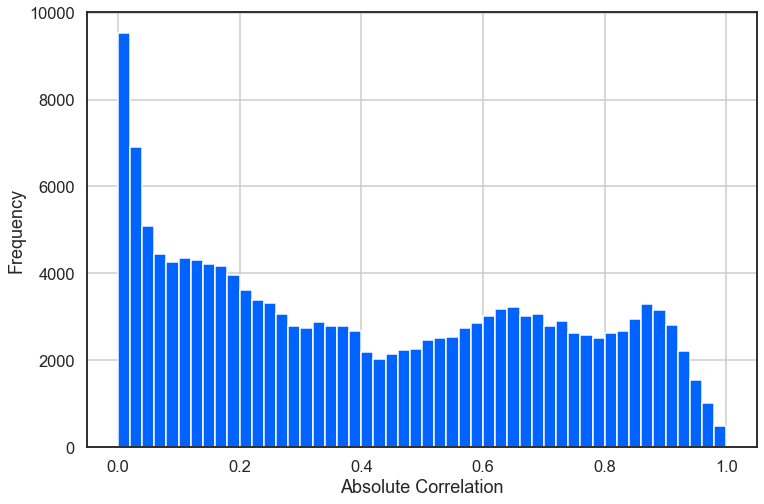

In [12]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [13]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


test train split
Using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [15]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

Fiting a logistic regression model without any regularization using all of the features. \
Using cross validation to determine the hyperparameters:
* fit models using L1 
* fit model usingd L2 

In [17]:
from sklearn.linear_model import LogisticRegression
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [18]:
from sklearn.linear_model import LogisticRegressionCV
# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [19]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)


In [20]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
477  0.001074  0.246611  0.257537 -0.143951  0.396428  0.348989 -0.205524   
139 -0.030751 -0.075709  0.028893  0.382306 -0.020514  0.237450  0.000000   
266 -0.049659 -0.139342 -0.451457  0.308954 -0.239224 -0.081093  0.068471   
2    0.030187  0.063196  0.245909  0.022339  0.058980 -0.402526  0.000000   
277  0.086075 -0.250780  0.147541  0.204376 -0.259073  0.084205  0.000000   
225  0.067467  0.163853 -0.348613 -0.395370  0.056091  0.483723  0.497006   
84  -0.065278 -0.193897 -0.370645  0.447255 -0.150235 -0.289431  0.110638   
343  0.001937  0.224749  0.239631  0.054800  0.061875  0.209171  0.000000   
74  -0.103817 -0.227167  0.241250 -0.309442 -0.179884  0.319094  0.000000   
385 -0.009631  0.166589  0.231053  0.054057  0.344868  0.220503 -0.072962   

                                                             l2            \
            1         2         3         4         5         0         1   
477  0.374921  0.282181  0.000000  0.432452  0.333234 -0.020658  0.683333   
139  0.000000  0.000000  0.253037  0.000000  0.750319 -0.039854 -0.068353   
266  0.000000 -1.250942  0.000000  0.000000  0.000000 -0.058645  0.063767   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.040581 -1.319199   
277  0.000000  0.000000  0.000000 -0.653830  0.175015  0.152546  0.557770   
225  0.000000 -0.664010 -0.172124  0.000000  1.327874  0.157606  0.464202   
84   0.000000 -0.051755  0.564725  0.000000 -0.821217 -0.110234 -0.661509   
343  0.061168  0.236694  0.000000  0.000000  0.305312 -0.018430  0.575269   
74   0.000000  0.072612 -0.037308  0.000000  0.000000 -0.194274 -1.317099   
385  0.000000  0.013456  0.000000  0.508555  0.108200 -0.036842  0.381692   

                                             
            2         3         4         5  
477  0.319338 -0.575750  0.790887  1.559459  
139  0.107940  0.771713 -0.314543  1.838947  
266 -0.658697  1.035979 -0.550657 -0.412504  
2    0.464227  0.134539  0.009766 -1.651815  
277  0.189939  0.476907 -0.548066  0.268312  
225 -0.384397 -0.974113  0.042391  1.972859  
84  -0.524852  1.029769 -0.254859 -1.096601  
343  0.300520  0.065357  0.101507  1.007904  
74   0.425362 -0.765805 -0.201115  0.331534  
385  0.334483  0.573386  0.868778  1.341331

plots for each of the multi-class coefficients.

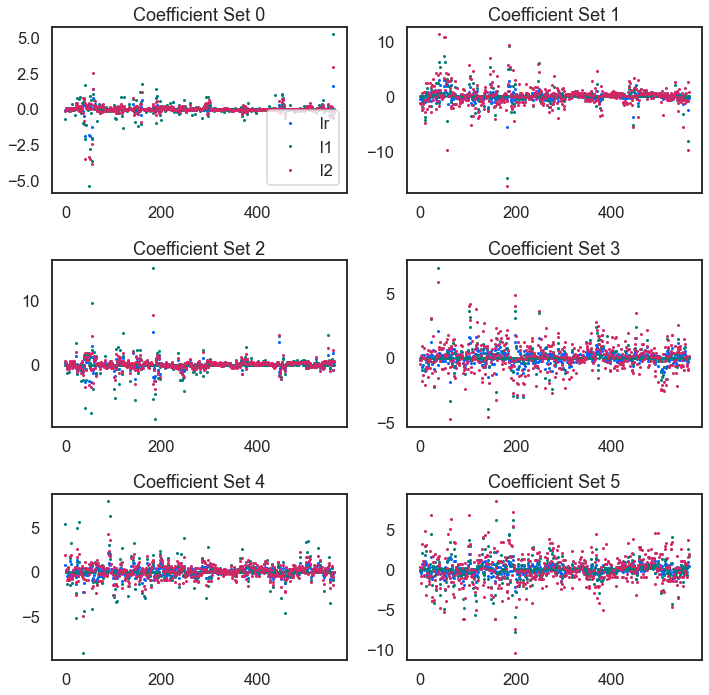

In [21]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()
### END SOLUTION

* Predict the class for each model.

In [22]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [23]:
y_prob.head()

,lr,l1,l2
0,0.998939,0.998895,0.999758
1,0.988165,0.999819,0.999477
2,0.987592,0.995703,0.999685
3,0.981381,0.999179,0.994337
4,0.998277,0.999919,0.999997


Calculate of the following error metrics: 

* Accuracy
* Precision
* Recall
* F-score
* Confusion Matrix

In [26]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)
metrics

,lr,l1,l2
precision,0.984144,0.983835,0.983824
recall,0.984142,0.983819,0.983819
fscore,0.984143,0.983815,0.983819
accuracy,0.984142,0.983819,0.983819
auc,0.990384,0.990144,0.990165


Display of the the confusion matrix for each model.

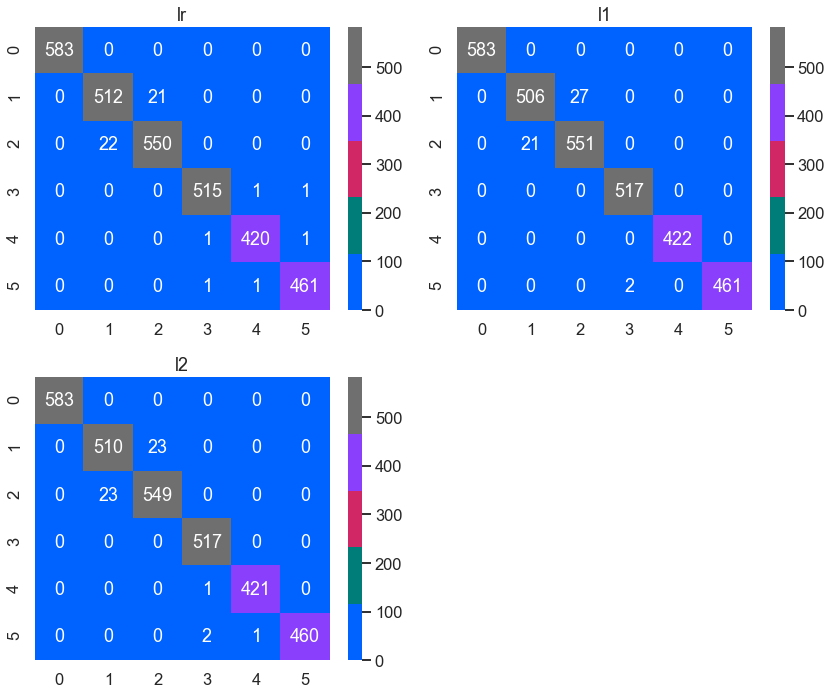

In [27]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap=colors);
    ax.set(title=lab);
    
plt.tight_layout()